## Import requirements

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import tensorflow as tf


In [2]:
num_classes = 14
wspan= 100
hspan = 100
nhood = 1

# Build and train a model

In [2]:
### Load Data
data = np.load("../../data/d0.npy")
for i in range(1,10):
    temp_data = np.load("../../data/d"+str(i)+".npy")
    data=np.concatenate((data,temp_data),axis=0)

In [3]:
data.shape

#data=data.reshape(len(data),2,100,100,1)
#data.shape

(145000, 2, 100, 100)

In [ ]:
### split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data[:,0], data[:,1],test_size=0.2)


In [6]:
Y_train_onehot = tf.squeeze(tf.one_hot(tf.cast(Y_train, tf.int32), num_classes))
Y_test_onehot = tf.squeeze(tf.one_hot(tf.cast(Y_test, tf.int32), num_classes))

In [ ]:
### save train test arrays
np.save('X_train.npy',X_train)
np.save('X_test.npy',X_test)
np.save('Y_train.npy',Y_train)
np.save('Y_test.npy',Y_test)

In [54]:
### load train and test arrays
#80
#X_train = np.load('X_train.npy')
#20
X_train = np.load('X_test.npy')
#20
#X_test = np.load('X_test.npy')
#80
#X_test = np.load('X_train.npy')
#80
#Y_train_onehot = np.load('Y_train_onehot.npy')
#20
#Y_train_onehot = np.load('Y_test_onehot.npy')
#20
#Y_test_onehot = np.load('Y_test_onehot.npy')
#80
#Y_test_onehot = np.load('Y_train_onehot.npy')
#80
#Y_train = np.load('Y_train.npy')
#20
#Y_train = np.load('Y_test.npy')
#80
#Y_test = np.load('Y_train.npy')
#20
#Y_test = np.load('Y_test.npy')

In [55]:
X_train.shape

(29000, 100, 100, 1)

In [5]:
#### Define and build model
tf.random.set_seed(0)
layer_dims = [100, 100, 100]
loss = lambda x, y : tf.keras.losses.categorical_crossentropy(tf.reshape(x, shape=(-1, num_classes)), 
                                                              tf.reshape(y, shape=(-1, num_classes)), 
                                                              from_logits=True)
diameter = 2*nhood+1
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer((wspan, hspan, 1)))
model.add(tf.keras.layers.Conv2D(layer_dims[0], kernel_size=[diameter, diameter], padding='same', 
                                 activation='relu', kernel_initializer=tf.keras.initializers.he_normal(), 
                                 bias_initializer=tf.keras.initializers.he_normal()))
for i in range(1, len(layer_dims)):
    model.add(tf.keras.layers.Dense(layer_dims[i],  activation='relu',
                                    kernel_initializer=tf.keras.initializers.he_normal(), 
                                    bias_initializer=tf.keras.initializers.he_normal()))
model.add(tf.keras.layers.Dense(num_classes,  activation='relu',
                                kernel_initializer=tf.keras.initializers.he_normal(), 
                                bias_initializer=tf.keras.initializers.he_normal()))

#model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3), loss=loss,metrics=['accuracy'])
model.compile(optimizer=tf.keras.optimizers.SGD(lr=1e-1, nesterov=True), loss=loss,metrics=['accuracy'])

EPOCHS = 150
checkpoint_filepath = 'best_working_SGD_nesterov_e-1_keras_temp.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 100)     1000      
_________________________________________________________________
dense_3 (Dense)              (None, 100, 100, 100)     10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100, 100, 100)     10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100, 100, 14)      1414      
Total params: 22,614
Trainable params: 22,614
Non-trainable params: 0
_________________________________________________________________


In [6]:
###  Load model
#file='best_working_SGD_nesterov_e-1_kerastemp.h5'
file='best_working_SGD_nesterov_e-1_keras.h5'
model.load_weights(file)

In [9]:
print(Y_train.shape)

NameError: name 'Y_train' is not defined

In [ ]:
#### Run training
train_history1 = model.fit(x=X_train, y=Y_train_onehot, epochs=50, batch_size=32,shuffle = True,verbose=1,validation_split=0.2,callbacks=[model_checkpoint_callback])
#train_history = model.fit(x=X_train, y=Y_train, epochs=EPOCHS, batch_size=14,shuffle = True,verbose=1,validation_split=0.2,callbacks=[model_checkpoint_callback])



Epoch 1/50
404/725 [===============>..............] - ETA: 53s - loss: 4.4718 - accuracy: 0.4743

In [7]:
train_loss = train_history.history['loss']+train_history1.history['loss'] 
val_loss = train_history.history['val_loss']+train_history1.history['val_loss']
plt.plot(train_loss, 'k',label="training loss",color='green')
plt.plot(val_loss, 'k',label="validation loss",color='red')
plt.xlabel('epochs', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.legend() 

NameError: name 'train_history' is not defined

In [8]:
### Evaluate the model
results = model.evaluate(X_test, Y_test_onehot, batch_size=32)

3625/3625 [==============================] - 201s 42ms/step - loss: 0.1643 - accuracy: 0.9569


In [9]:
print("test loss, test accuracy : ",results)

test loss, test accuracy :  [0.16298702359199524, 0.957288384437561]


In [11]:
X_test = X_test[..., tf.newaxis]
Y_test = Y_test[..., tf.newaxis]

In [20]:
labels = tf.argmax(tf.nn.softmax(model(X_test[:13])), axis=-1)
Y_pred = tf.reshape(labels, (-1, wspan, hspan))

input [[8. 0. 8. ... 8. 0. 0.]
 [0. 8. 8. ... 0. 0. 0.]
 [8. 8. 0. ... 8. 8. 8.]
 ...
 [8. 8. 0. ... 8. 0. 8.]
 [0. 0. 0. ... 0. 0. 8.]
 [8. 8. 8. ... 8. 8. 0.]]
expected [[9. 0. 9. ... 9. 0. 0.]
 [0. 9. 9. ... 0. 0. 0.]
 [9. 9. 0. ... 9. 9. 9.]
 ...
 [9. 9. 0. ... 9. 0. 9.]
 [0. 0. 0. ... 0. 0. 9.]
 [9. 9. 9. ... 9. 9. 0.]]
obswered tf.Tensor(
[[9 0 9 ... 9 0 0]
 [0 9 9 ... 0 0 0]
 [9 9 0 ... 9 9 9]
 ...
 [9 9 0 ... 9 0 9]
 [0 0 0 ... 0 0 9]
 [9 9 9 ... 9 9 0]], shape=(100, 100), dtype=int64)


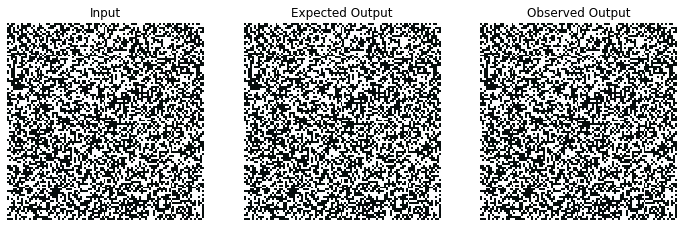

In [53]:
### Plot results

## Generate testing data
#X_test = tf.convert_to_tensor(np.moveaxis(np.dstack([make_glider(10), make_glider(10)]), 2, 0), tf.float32)
# X_test = tf.convert_to_tensor(make_glider(10), tf.float32)[tf.newaxis, ...]
#Y_test = gol(X_test)
temp=1

tau_i = 4 
tau_r = 9
tau_0 = tau_i+tau_r

##Define discreet colormap
cmap = colors.ListedColormap(['xkcd:pale grey','xkcd:darkish red','xkcd:almost black'])
bounds = [0,0.99,tau_i+0.99,tau_0+0.99]
norm = colors.BoundaryNorm(bounds,cmap.N)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(tf.squeeze(X_test[temp]),cmap=cmap,norm=norm,interpolation='none')
plt.axis('off')
plt.title("Input")
print('input',X_test[temp].reshape(100,100))
plt.subplot(1,3,2)
plt.imshow(tf.squeeze(Y_test[temp]),cmap=cmap,norm=norm,interpolation='none')
plt.axis('off')
plt.title("Expected Output")
print('expected',Y_test[temp].reshape(100,100))
plt.subplot(1,3,3)
plt.imshow(tf.squeeze(Y_pred[temp]),cmap=cmap,norm=norm,interpolation='none')
plt.axis('off')
plt.title("Observed Output")
print('obswered',Y_pred[temp])


In [18]:
### Save and load a model
model.save('keras_model.h5')
#del model
#model = tf.keras.models.load_model('path_to_my_model.h5', custom_objects={'Wraparound2D': Wraparound2D})

# Show activation patterns of hidden layers

In [ ]:
import tensorflow.keras.backend as K

inp = model.input                                           # input placeholder
outputs = [layer.output for layer in model.layers]          # all layer outputs
functor = K.function(inp, outputs)   # evaluation function

layer_outs = functor([X_test, 1.])



# Plot activations of different neurons in different layers 
all_layer_activations = list()

min_max_scaler = lambda x : (x - np.min(x))/(np.max(x) - np.min(x))
# min_max_scaler = lambda x : (x - np.mean(x))
for j in range(1, 5):
    if j==1:
        layer_im = np.hstack([min_max_scaler(layer_outs[1][0][..., i]) for i in range(10)])
    else:
        pattern = np.reshape(layer_outs[j][0], (wspan, hspan, -1))
        layer_im = np.hstack([min_max_scaler(pattern[..., i]) for i in range(10)])
    all_layer_activations.append(layer_im)

        
plt.figure()
plt.imshow(np.vstack(all_layer_activations))
plt.title("Activations of hidden layers given \"Glider\" input")

plt.figure()
plt.imshow(np.squeeze(np.dstack(model.layers[1].weights[0].numpy())))
plt.title("Convolutional filters")